## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [2]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [13]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File 'data.txt' already there; not retrieving.



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [1]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [2]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [5]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9284
Unique tokens in target (en) vocabulary: 6718


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 'прогулку',
 'point',
 'книг',
 'antica',
 'фасадом',
 'margarita',
 'таормина',
 'декорированные',
 'стереосистемой']

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::1000]

['<unk>', 'speed', 'classical', 'belvedere', 'morro', 'salami', 'magazine']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[9]))

{'trg': ['if', 'you', 'feel', 'like', 'visiting', 'the', 'surroundings', ',', 'check', 'out', 'discovery', 'chair', '(', '11', ')', '(', '200', 'metres', ')', 'and', 'broadway', 'express', '(', '1', ')', '(', '300', 'metres', ').'], 'src': ['в', '200', 'метрах', 'находится', 'станция', 'лыжного', 'подъемника', '«', 'дискавери', 'чэир', '»', '(', '11', '),', 'а', 'в', '300', 'метрах', '—', 'станция', '«', 'бродвей', 'экспресс', '»', '(', '1', ').']}


Let's check the length distributions:

Length distribution in Train data


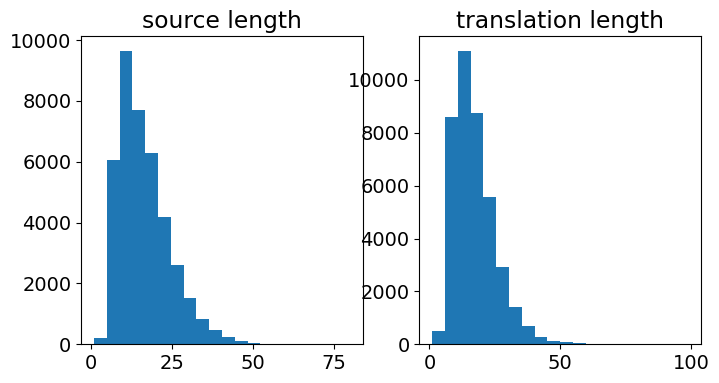

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


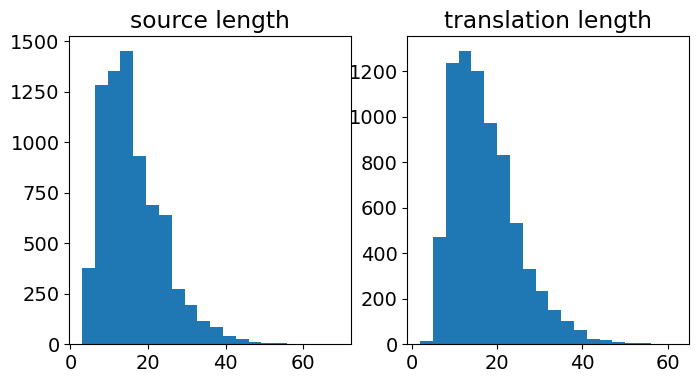

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 42x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 45x128 (GPU 0)]
torch.Size([45, 128]) torch.Size([42, 128])


In [20]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9284, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6718, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6718, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,899,262 trainable parameters


In [24]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

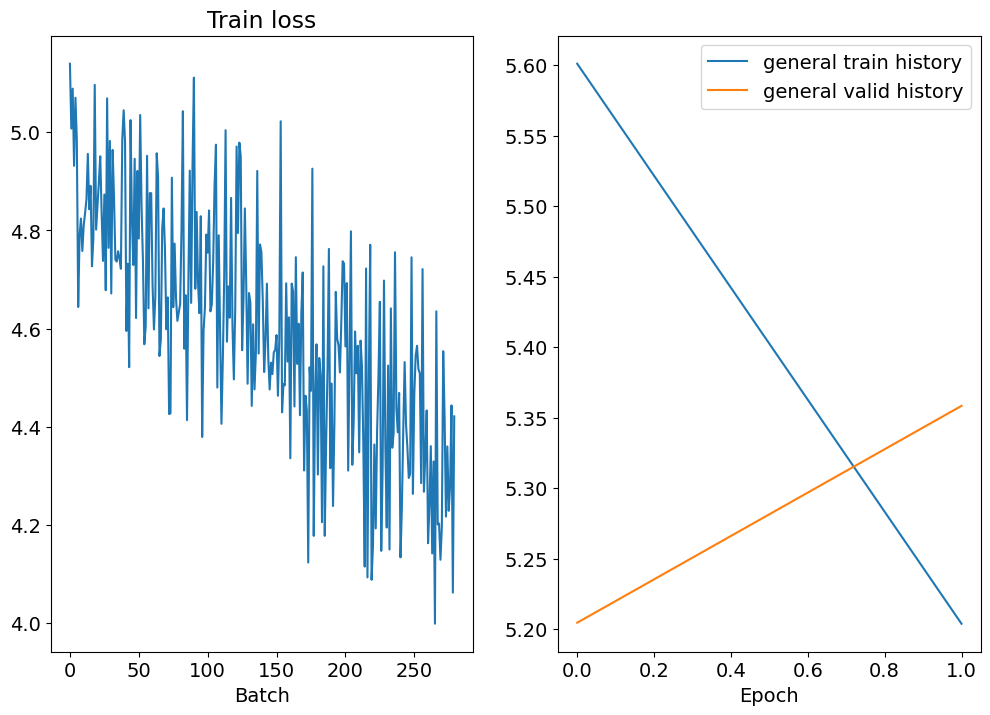

In [29]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
# del utils

In [40]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

/tmp/ipykernel_2874/3680124227.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [66]:
batch = next(iter(test_iterator))

In [67]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk .

Original: the complex also has a handy on - site supermarket .
Generated: a a - minute walk .



In [43]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [38]:
import tqdm

In [69]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

0it [00:00, ?it/s]

59it [00:05, 11.26it/s]


In [46]:
seq2seq_bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(seq2seq_bleu)

28.15490046928225


# Attention mechanism

In [71]:
import attention_mechanism
AttentionEncoder = attention_mechanism.Encoder
AttentionDecoder = attention_mechanism.Decoder
AttentionSeq2Seq = attention_mechanism.Seq2Seq

In [72]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = AttentionEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = AttentionSeq2Seq(enc, dec, device).to(device)

In [73]:
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,004,360 trainable parameters


In [74]:
PAD_IDX = TRG.vocab.stoi['']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [75]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 5

best_valid_loss = float('inf')

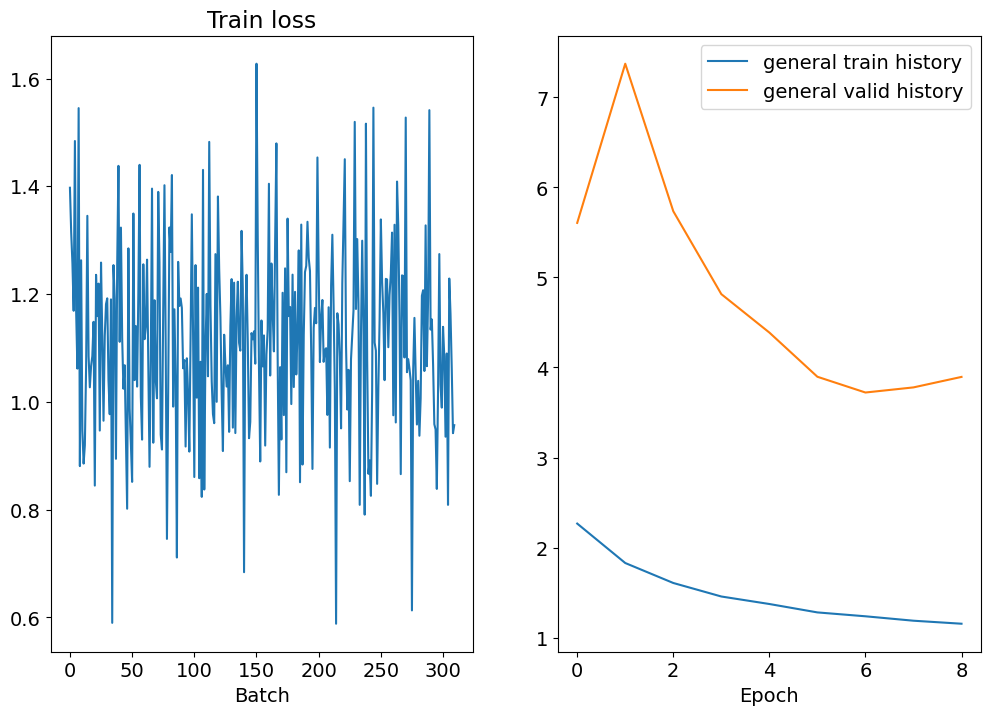

Epoch: 10 | Time: 2m 23s
	Train Loss: 1.115 | Train PPL:   3.048
	 Val. Loss: 3.668 |  Val. PPL:  39.183


In [90]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [91]:
batch = next(iter(test_iterator))

In [92]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: kettle desk is a a a a a a a a a a a

Original: the complex also has a handy on - site supermarket .
Generated: is a a a .



In [93]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:05, 10.11it/s]


In [94]:
seq2seq_attention_bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(seq2seq_attention_bleu)

16.099354000555635


# BPE

In [9]:
import sentencepiece as spm
import pandas as pd

data = pd.read_csv(path_do_data, sep = "\t", header = None).sample(frac = .8)
data[0].to_csv("eng.txt", sep = '\t', header = False, index = False)
data[1].to_csv("ru.txt", sep = '\t', header = False, index = False)

spm.SentencePieceTrainer.train(input = 'ru.txt', model_prefix = 'm_ru', vocab_size = 2500, model_type = 'bpe')
spm.SentencePieceTrainer.train(input = 'eng.txt', model_prefix = 'm_eng', vocab_size = 2500, model_type = 'bpe')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ru.txt
  input_format: 
  model_prefix: m_ru
  model_type: BPE
  vocab_size: 2500
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privac

 all=19865 active=3194 piece=▁оформлен
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=1039 min_freq=237
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=996 size=520 all=20227 active=1351 piece=им
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=959 size=540 all=20528 active=1652 piece=уточ
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=921 size=560 all=20744 active=1868 piece=▁дом
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=879 size=580 all=20953 active=2077 piece=зала
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=848 size=600 all=21376 active=2500 piece=▁Та
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=847 min_freq=200
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=804 size=620 all=21749 active=1406 piece=ве
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=775 size=640 all=22200 active=1857 piece=сс
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=726 size=660 all=22583 active=2240 piece=▁занима
bpe_model_trainer.cc(268) LOG(INFO) Ad

In [10]:
def bpe_tokenizer_en(x):
  return spm.SentencePieceProcessor(model_file = 'm_eng.model').encode(x, out_type = str)

In [11]:
def bpe_tokenizer_ru(x):
  return spm.SentencePieceProcessor(model_file = 'm_ru.model').encode(x, out_type = str)

In [16]:
SRC = Field(tokenize=bpe_tokenizer_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            fix_length = 100,
            lower = True)

TRG = Field(tokenize=bpe_tokenizer_ru,
            init_token = '<sos>',
            eos_token = '<eos>',
            fix_length = 100,
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [17]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [18]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [19]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [20]:
print(f"Number of unique tokens in source (RU) vocabulary: {len(SRC.vocab)}")
print(f"Number of unique tokens in target (EN) vocabulary: {len(TRG.vocab)}")

Number of unique tokens in source (RU) vocabulary: 8820
Number of unique tokens in target (EN) vocabulary: 389


In [24]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [28]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [29]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [30]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8820, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(389, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=389, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

NameError: name 'model' is not defined

In [32]:
PAD_IDX = TRG.vocab.stoi['']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [33]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

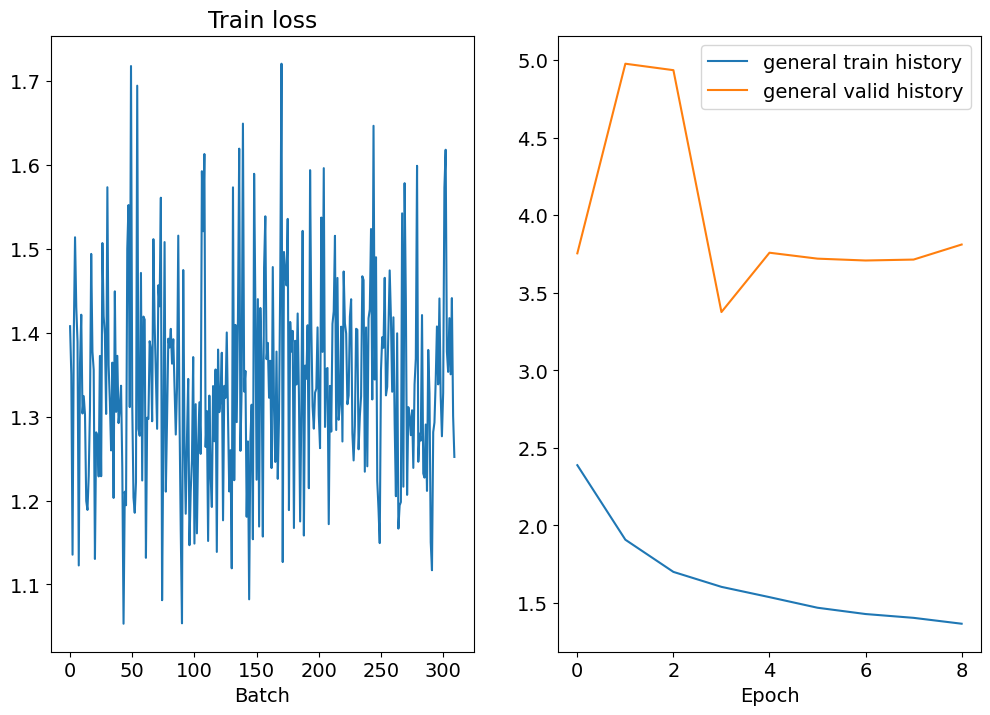

Epoch: 10 | Time: 1m 50s
	Train Loss: 1.340 | Train PPL:   3.820
	 Val. Loss: 3.784 |  Val. PPL:  43.996


In [34]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [35]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

/tmp/ipykernel_3499/3680124227.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [36]:
batch = next(iter(test_iterator))

In [38]:
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

0it [00:00, ?it/s]

59it [00:07,  7.75it/s]


In [41]:
seq2seq_bpe_bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(seq2seq_bpe_bleu)

19.542397904037006

# Transformer

In [9]:
from transformer import Seq2SeqTransformer

In [24]:
torch.manual_seed(0)
PAD_IDX = TRG.vocab.stoi['']

SRC_VOCAB_SIZE = len(SRC.vocab)
TGT_VOCAB_SIZE = len(TRG.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, 
                                 NUM_DECODER_LAYERS, 
                                 EMB_SIZE, 
                                 NHEAD, 
                                 SRC_VOCAB_SIZE, 
                                 TGT_VOCAB_SIZE, 
                                 FFN_HID_DIM)

/home/stanislav/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [25]:
for param in transformer.parameters():
    if param.dim() > 1:
        nn.init.xavier_uniform_(param)

In [26]:
transformer = transformer.to(device)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [27]:
def generate_square_subsequent_mask(sz, device_):
    mask = (torch.triu(torch.ones((sz, sz), device=device_)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, device_):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device_).type(torch.bool)
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device_)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [28]:
def train_epoch(model, 
                optimizer, 
                iterator, 
                DEVICE, 
                train_history=None, 
                valid_history=None):
    model.train()
    losses = 0
    history = []
    
    for i, batch in enumerate(iterator):
        src = batch.src.to(DEVICE)
        tgt = batch.trg.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        logits = model(src, 
                       tgt_input, 
                       src_mask, 
                       tgt_mask,
                       src_padding_mask, 
                       tgt_padding_mask, 
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
        # plot
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        

    return losses / len(iterator)


def evaluate(model, 
             iterator, 
             DEVICE):
    model.eval()
    losses = 0

    for i, batch in enumerate(iterator):
        src = batch.src.to(DEVICE)
        tgt = batch.trg.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(iterator)

In [32]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 24,252,474 trainable parameters


In [33]:
train_history = []
valid_history = []

N_EPOCHS = 10

best_valid_loss = float('inf')

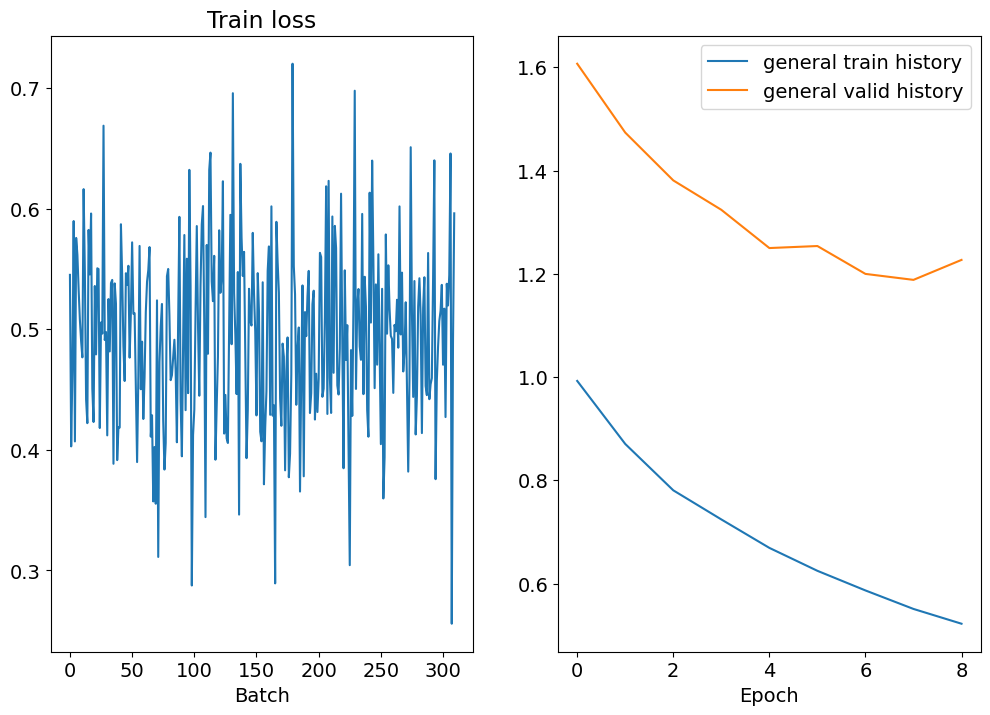

Epoch: 10 | Time: 1m 30s
	Train Loss: 0.495 | Train PPL:   1.640
	 Val. Loss: 1.804 |  Val. PPL:   6.072


In [36]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train_epoch(transformer, optimizer, train_iterator, device, train_history, valid_history)
    val_loss = evaluate(transformer, valid_iterator, device)

    end_time = time.time()

    train_history.append(train_loss)
    valid_history.append(val_loss)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [41]:
transformer.eval()
original_text = []
generated_text = []

with torch.no_grad():

  for i, batch in tqdm.tqdm(enumerate(test_iterator)):
      src = batch.src.to(device)
      tgt = batch.trg.to(device)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, device)

      logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
      
      tgt_out = tgt[1:, :]
      logits = logits.argmax(dim=-1)
      generated_text.extend([get_text(x, TRG.vocab) for x in logits.cpu().numpy().T])
      original_text.extend([get_text(x, TRG.vocab) for x in tgt.cpu().numpy().T])

59it [00:03, 18.59it/s]


In [44]:
transformer_bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(transformer_bleu)

28.15490046928225


# Conclusion

In this homework I have made 3 improvements to the original translation model, let's depict the resulting BLEU metrics.

In [45]:
import matplotlib.pyplot as plt

# I reboot ipynb so hardcode previous results
seq2seq_bleu = 
seq2seq_attention_bleu = 16.099354000555635
seq2seq_bpe_bleu = 19.542397904037006
transformer_bleu = 28.15490046928225

variables = ['Baseline', 'Attention', 'BPE', 'Transformer']
values = [seq2seq_bleu, seq2seq_attention_bleu, seq2seq_bpe_bleu, transformer_bleu]

plt.figure(figsize=(6, 6))
plt.title('BLEU values for different models')
plt.xlabel('BLEU')
plt.ylabel('model')

plt.bar(variables, values)
plt.show()

NameError: name 'seq2seq_bleu' is not defined

It can be seen that the transformer is the most powerful model. 